# Demo for pre-training a ScafVAE
## Step 1. Loading dependencies
### First, select a folder for temporarily saving (in this demo, we use ./cache for temporary saving). Please change the path of model_param_path in ScafVAE_ROOT/model/config.yml to the absolute path of that folder.
P.S. Please make sure to use the absolute path in config.yml

In [3]:
cache_path = './cache'  # for saving data and model
%store cache_path

device = 'cuda:0'
%store device

Stored 'cache_path' (str)
Stored 'device' (str)


In [4]:
import os
os.system(f'rm -rf {cache_path}')
from ScafVAE.app.demo_utils import *
from ScafVAE.utils.common import *

delmkdir(cache_path)

## Step 2. Data preparation
### Loading dataset

In [5]:
smi_list = get_demo_smi()[:10000]  # We load a small molecule set derived from the ChEMBL database. You can change the size of the training dataset or load your own molecule set here (a list of SMILES)
smi_list[:3]

['CCCCN1C(=O)C(CC(=O)O)NC(=O)C12CCN(Cc1ccc(Oc3ccccc3)cc1)CC2',
 'COC(=O)[C@H](NC(=O)CC(=O)O)C(C)C',
 'C[C@H](NCC(=O)Nc1cccc(Br)c1)c1ccc(C(F)F)nc1']

### Preparing features for molecules

In [6]:
prepare_demo_smi_feat(cache_path, smi_list)

Preparing molecular features:   0%|          | 0/10000 [00:00<?, ?it/s]

### Calculating bond perplexity

In [7]:
prepare_demo_ppl(cache_path, device=device, batch_size=8)

Loading PPLPredictor parameters ...
Loading PPLPredictor parameters ...
Set dataset to [0:9802]


100%|███████████████████████████████████████████████████████████████████████████████████████████| 1226/1226 [07:12<00:00,  2.84it/s]


### Perplexity-inspired fragmentation

In [8]:
prepare_demo_scaf(cache_path)

Preparing scaffolds: 100%|██████████████████████████████████████████████████████████████████████| 9802/9802 [08:17<00:00, 19.71it/s]

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Unique bond scaffold: 851


Counting scaffolds: 100%|█████████████████████████████████████████████████████████████████████| 7791/7791 [00:06<00:00, 1155.49it/s]


## Step 3. Training
### Please restart the Python kernel here to reload the prepared configurations !!!

In [1]:
from ScafVAE.app.demo_utils import *
%store -r cache_path
%store -r device

model, config = train_toy_model(
    cache_path,
    device=device,
    batch_size=32,
    n_epoch=20,
    lr=1e-3,
    lr_decay=0.9,
)
torch.save({'model_state_dict': model.state_dict(), 'args': config}, f'{cache_path}/ScafVAE.chk')  # save model

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch [1/20]
244/244 [==============================] - 296s 1s/step - fp_acc: 0.8504 - x_scaf_pred_metric: 24.0033 - edge_scaf_pred_metric: 4.3812 - x_aa_pred_metric: 10.5705 - edge_bond_pred_metric: 10.9973 - kl_metric: 608.9574 - cl_metric: 3.1549 - cl_embed_1_norm_penalty: 17.9896 - cl_embed_2_norm_penalty: 17.9586 - fp_metric: 0.3848
Adjusting learning rate of group 0 to 9.0000e-04.
Epoch [2/20]
244/244 [==============================] - 291s 1s/step - fp_acc: 0.8636 - x_scaf_pred_metric: 22.6956 - edge_scaf_pred_metric: 3.9065 - x_aa_pred_metric: 7.4523 - edge_bond_pred_metric: 9.5796 - kl_metric: 440.5995 - cl_metric: 2.3850 - cl_embed_1_norm_penalty: 8.8541 - cl_embed_2_norm_penalty: 8.8276 - fp_metric: 0.3613
Adjusting learning rate of group 0 to 8.1000e-04.
Epoch [3/20]
244/244 [==============================] - 292s 1s/step - fp_acc: 0.8674 - x_scaf_pred_metric: 22.1260 - edge_scaf_pred_metric: 3.6925 - x_aa_pred_metric: 6.74

## Step 4. Visualization

### (Optional) Loading a trained model (if you start from here without running cells above)

#### To load your own trained model, please change the path of "model_param_path" in ScafVAE_ROOT/model/config.yml to the absolute path of "cache_path", uncomment code below, restart the Python kernel and run cells below. P.S. Please use the absolute path in config.yml

#### To load the trained model provided by authors, please change the path of "model_param_path" in ScafVAE_ROOT/model/config.yml to default, uncomment code below, restart the Python kernel and run cells below

In [ ]:
# from collections import defaultdict
# from ScafVAE.app.demo_utils import *
# from ScafVAE.utils.graph2mol import *
# from ScafVAE.utils.common import *
#
# device = 'cpu'
# model = ModelBase(None).to(device)
# model.load_state_dict(load_ModelBase()['model_state_dict'])

### Sampling molecules

In [4]:
n_sample = 100
batch_size = 50

model.train(False)
dic_save = defaultdict(list)
for _ in tqdm(range(n_sample // batch_size)):
    dic_output = model.frag_decoder.sample(
        batch_size=batch_size,
    )
    dic_save['generated_smi'] += dic_output['smi']

valid_smi = [i for i in dic_save['generated_smi'] if i is not None][:n_sample]
print(f'Valid moleucles: {len(valid_smi)}')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.27s/it]

Valid moleucles: 100


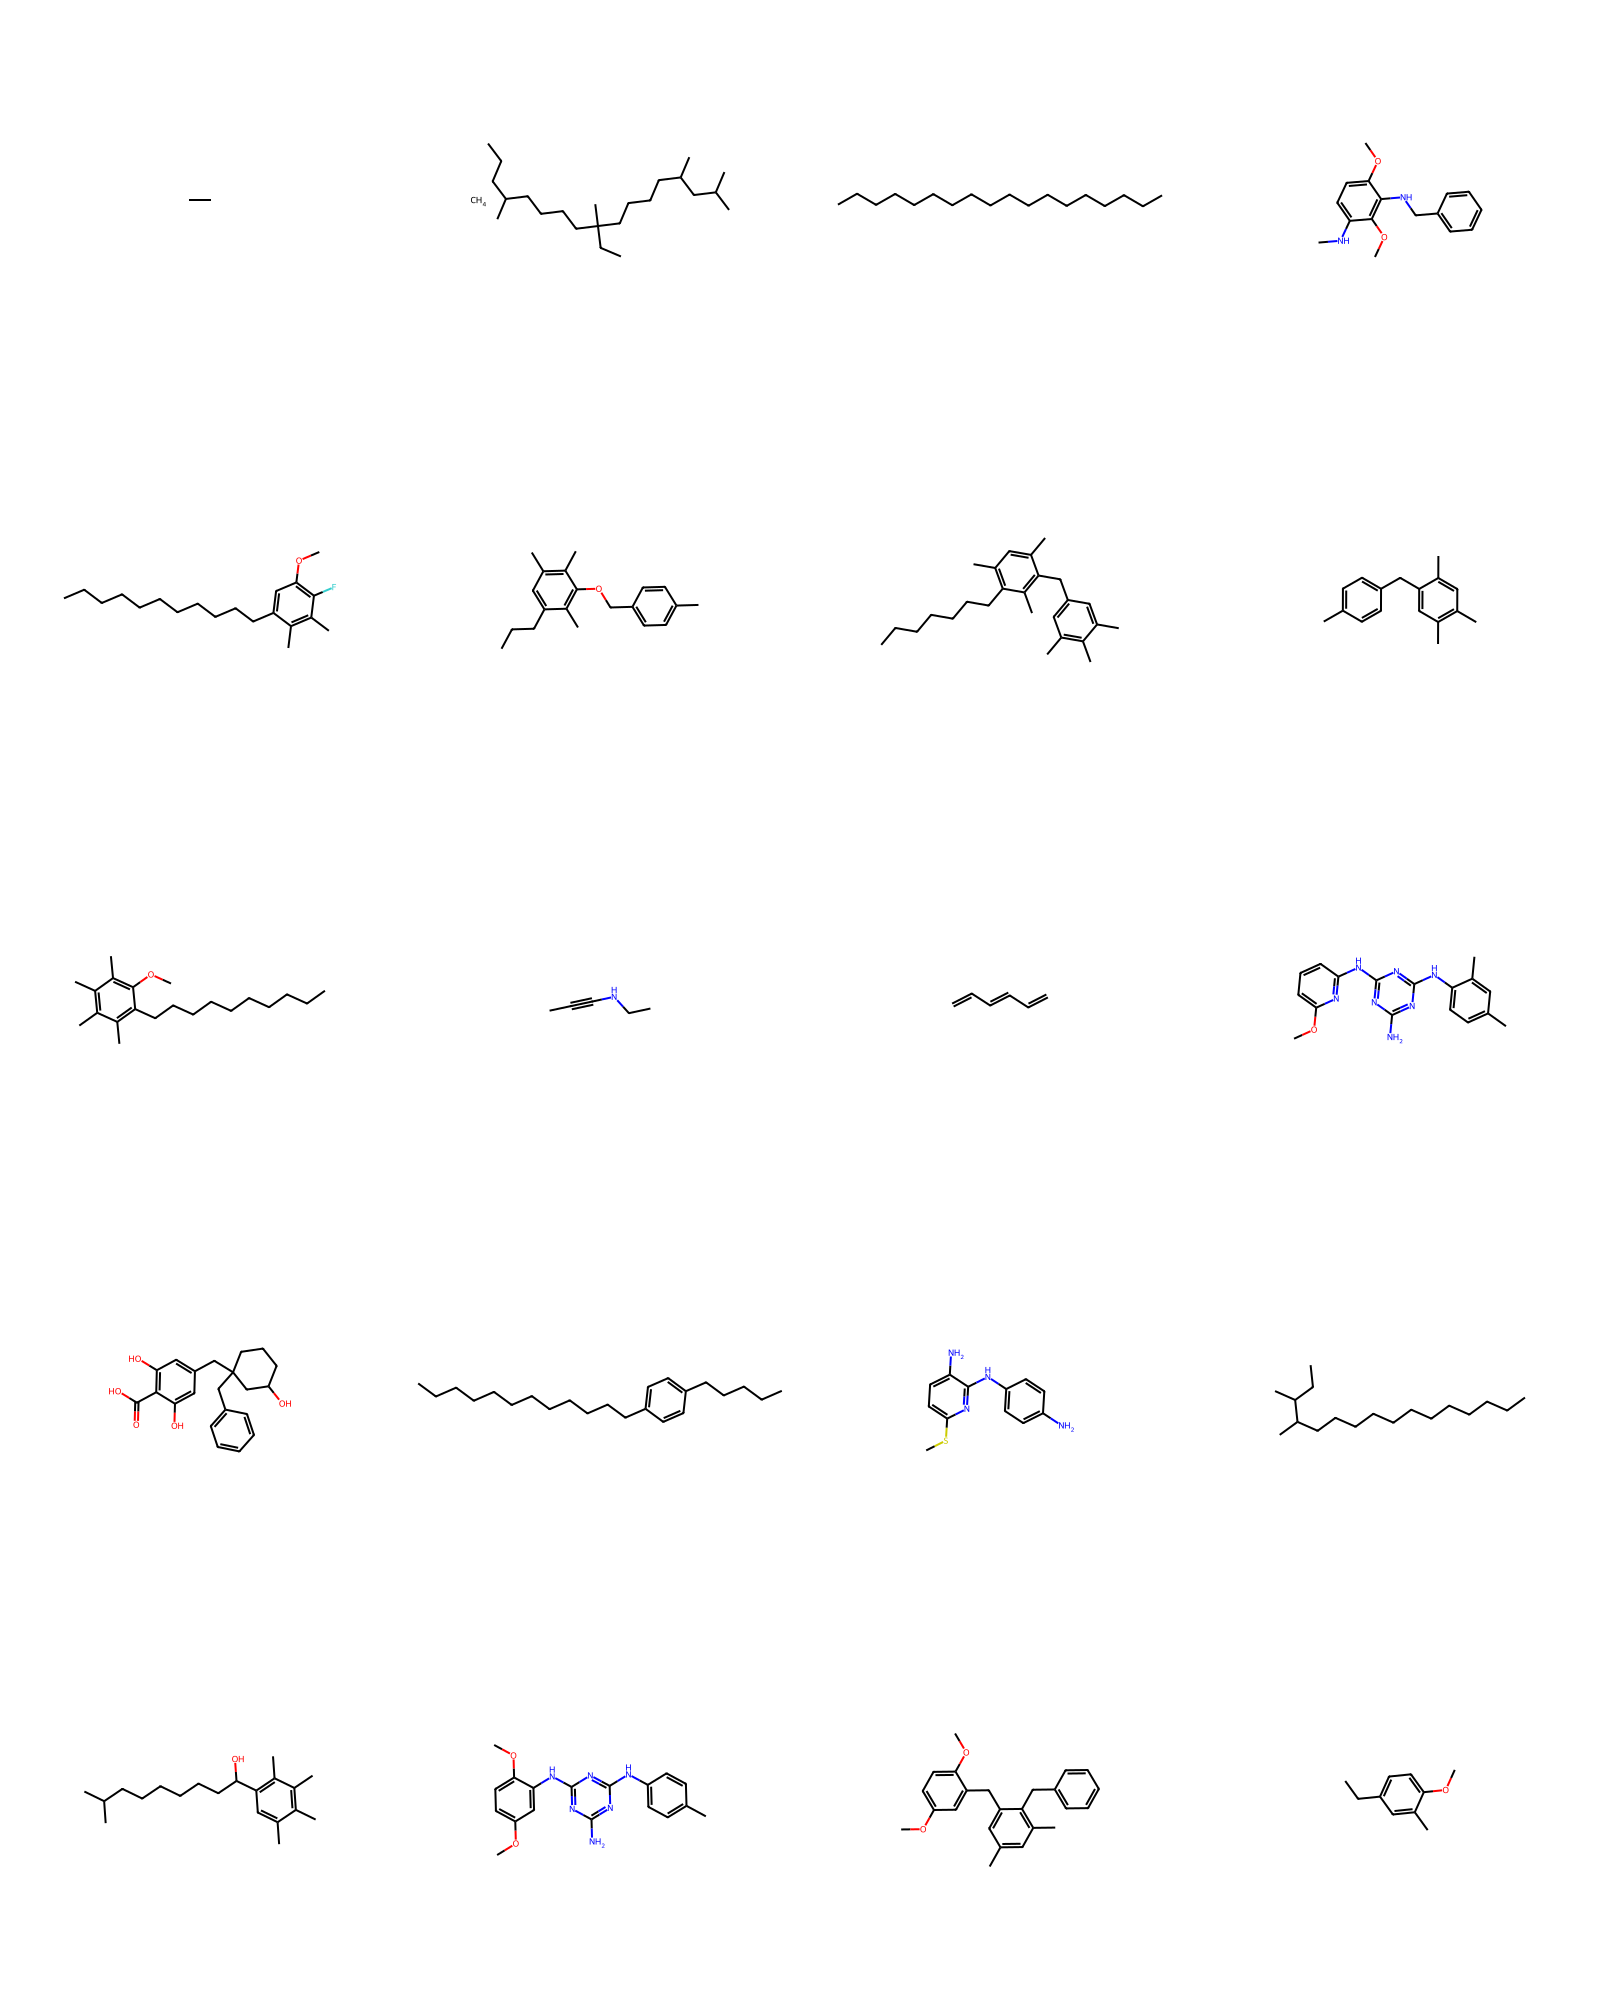

In [5]:
show_mols([Chem.MolFromSmiles(smi) for smi in valid_smi][:20], add_idx=False)